# Analysis of Advertising Sources and User Behavior in the Mobile Game "Space Brothers"

Research Goal - To analyze user behavior depending on the source of entry into the game.

The analysis is based on data on events in the mobile game "Space Brothers" and information on advertising activities and user acquisition sources.

The dataset contains event data for users playing the first level. It includes data from the initial cohort of app users who started using the app between May 4 and May 10.

1. [Data Collection and General Overview](#loading)
2. [Data Preprocessing](#preprocessing)
3. [Exploratory Data Analysis](#analysis)
     * [Calculation of metrics for each user – acquisition time, number of objects built, source of game entry, acquisition cost, level completion method, level completion time](#calculation)
     * [Advertising expenses broken down by acquisition channels](#cost)
     * [Trends in the number of new users and the cost of acquiring one user, broken down by sources](#count_new_user)
     * [User distribution by level completion method](#users)
     * [User distribution by level completion time and number of objects built](#users_2)
     
4. [Analysis of the impact of the game entry source on user behavior](#transition_source)
     * [Level completion time by user, broken down by game entry source ](#time)
     * [Number of objects built by a user, broken down by game entry source](#buildings)
     * [Level completion methods, broken down by game entry source](#methods)
     
5. [Statistical hypothesis testing](#hypotheses)
     * [Hypothesis 1: The level completion time differs depending on the method of completing the level](#hypothes_1)
     * [Hypothesis 2: The number of objects built by a user differs depending on the traffic source](#hypothes_2)
     
6. [General Conclusion](#conclusion)

## Data Collection and General Overview<a id="loading"></a>

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

In [17]:
game_actions = pd.read_csv('datasets/game_actions.csv')
ad_costs = pd.read_csv('datasets/ad_costs.csv')
user_source = pd.read_csv('datasets/user_source.csv')
game_actions.info()
display(game_actions.head(5))
ad_costs.info()
display(ad_costs.head(5))
user_source.info()
display(user_source.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB


,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes


,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB


,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads


The study uses three datasets: `game_actions`, `ad_costs`, and `user_source`. The `game_actions` dataset contains user activity data, `ad_costs` includes advertising information, and `user_source` provides acquisition sources.
Missing values are only present in `game_actions`. Both `game_actions` and `ad_costs` contain date columns with incorrect data types (object instead of datetime).

## Data Preprocessing  <a id="preprocessing"></a>

In [18]:
# Check for missing values
game_actions.isnull().sum()

event_datetime         0
event                  0
building_type       7683
user_id                0
project_type      133774
dtype: int64

Missing values in `game_actions` are due to the fact that not all columns need to be filled for each event. For example, building_type is only filled if event = building, so missing values should be left as-is.

In [19]:
# Duplicate handling
for name, table in [['game_actions', game_actions], ['ad_costs', ad_costs], ['user_source', user_source]]:
    print(f'Number of duplicates in {name} - {table.duplicated().sum()}')

# Duplicates in the game_actions dataset
game_actions[game_actions.duplicated()]
game_actions.drop_duplicates(inplace=True)

# Verify duplicate removal
print(f'Number of duplicates in game_actions after removal - {game_actions.duplicated().sum()}')

Number of duplicates in game_actions - 1
Number of duplicates in ad_costs - 0
Number of duplicates in user_source - 0
Number of duplicates in game_actions after removal - 0


A duplicate was found only in game_actions, likely an error. Since event times are recorded to the second, the same user cannot build two objects in the same second. Therefore, the duplicate should be removed.

In [20]:
# Converting data types to datetime
game_actions['event_datetime'] = pd.to_datetime(game_actions['event_datetime'], format='%Y-%m-%d %H:%M:%S')
ad_costs['day'] = pd.to_datetime(ad_costs['day'], format='%Y-%m-%d').dt.date
display(game_actions.dtypes)
ad_costs.dtypes

event_datetime    datetime64[ns]
event                     object
building_type             object
user_id                   object
project_type              object
dtype: object

source     object
day        object
cost      float64
dtype: object

Convert object to datetime in `game_actions` and `ad_costs`.

In [21]:
# Check for errors in the data
# Check date ranges
print(f'Minimum date in game_actions - {game_actions.event_datetime.min()}, maximum date - {game_actions.event_datetime.max()}')
print(f'Minimum date in ad_costs - {ad_costs.day.min()}, maximum date - {ad_costs.day.max()}')

# Check unique values in game_actions columns
for col in ['event', 'building_type', 'project_type']:
    print('-'* 25)
    print(col, game_actions[col].sort_values().unique())

# Check unique values in ad_costs columns
print('-'* 25)
print(f'ad_costs.source - {ad_costs.source.sort_values().unique()}')
print(f'Minimum value of cost - {ad_costs.cost.min()}, maximum value of cost - {ad_costs.cost.max()}')

# Check unique values in user_source columns
print('-'* 25)
print(f'user_source.source - {user_source.source.sort_values().unique()}')

Minimum date in game_actions - 2020-05-04 00:00:01, maximum date - 2020-06-05 12:32:49
Minimum date in ad_costs - 2020-05-03, maximum date - 2020-05-09
-------------------------
event ['building' 'finished_stage_1' 'project']
-------------------------
building_type ['assembly_shop' 'research_center' 'spaceport' nan]
-------------------------
project_type ['satellite_orbital_assembly' nan]
-------------------------
ad_costs.source - ['facebook_ads' 'instagram_new_adverts' 'yandex_direct'
 'youtube_channel_reklama']
Minimum value of cost - 23.314669267402746, maximum value of cost - 969.1393939421928
-------------------------
user_source.source - ['facebook_ads' 'instagram_new_adverts' 'yandex_direct'
 'youtube_channel_reklama']


The minimum date in the `ad_costs dataset` is one day earlier than the minimum date in `game_actions`. This is because the advertising is paid one day before placement. Therefore, to ensure accurate data analysis, one day should be added to the `ad_costs['day']` column. 

No other errors or inconsistencies were found in the remaining data

In [22]:
# Adding one day to the dates in ad_costs
print(f'Minimum date in ad_costs - {ad_costs.day.min()}, maximum date - {ad_costs.day.max()}')
ad_costs['day'] = ad_costs['day'] + pd.Timedelta(days=1)
print(f'Minimum date after adding 1 day to ad_costs - {ad_costs.day.min()}, maximum date - {ad_costs.day.max()}')

Minimum date in ad_costs - 2020-05-03, maximum date - 2020-05-09
Minimum date after adding 1 day to ad_costs - 2020-05-04, maximum date - 2020-05-10


No significant errors were found in the data. The column names are correct, and the dates comply with the task requirements. 
One duplicate was removed from the `game_actions` dataset. The data type was changed to datetime in `ad_costs['day']` and `game_actions['event_datetime']`. 
One day was added to the data in the `ad_costs['day']` column.

## Exploratory Data Analysis  <a id="analysis"></a>  

### Calculation of metrics for each user – acquisition time, number of objects built, source of game entry, acquisition cost, level completion method, level completion time  <a id="calculation"></a>  

In [23]:
# Calculation of client acquisition date and time and the number of buildings built
users = game_actions.groupby('user_id', as_index=False).agg({'event_datetime':['min', 'max'],
                                                             'building_type':'count'})
users.columns = ['user_id', 'date_start', 'date_end', 'build_count']
users['day'] = users['date_start'].dt.date

# Adding the user acquisition source to the grouped table
users = pd.merge(users, user_source, left_on='user_id', right_on='user_id')

# Calculation of the acquisition cost per user
users_count = users.groupby(['day', 'source'], as_index=False)['user_id'].count()
ad_costs_group = ad_costs.groupby(['day', 'source'], as_index=False)['cost'].sum()

cost_per_user = pd.merge(ad_costs_group, users_count, left_on=['day','source'], right_on=['day','source'])
cost_per_user.rename(columns={'user_id':'users_count'}, inplace=True)
cost_per_user['cost_per_user'] = cost_per_user['cost']/cost_per_user['users_count']

# Adding the acquisition cost per user to the grouped table
users = pd.merge(users, cost_per_user[['day','source', 'cost_per_user']], left_on=['day','source'], right_on=['day','source'])
users.head(5)

,user_id,date_start,date_end,build_count,day,source,cost_per_user
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06 01:07:37,2020-05-20 11:26:06,13,2020-05-06,facebook_ads,0.754162
1,00151b4f-ba38-44a8-a650-d7cf130a0105,2020-05-06 03:09:12,2020-05-18 10:46:52,9,2020-05-06,yandex_direct,0.464206
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,2020-05-05 18:08:52,2020-05-14 09:21:27,4,2020-05-05,youtube_channel_reklama,0.390759
3,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05 21:02:05,2020-05-12 07:40:47,8,2020-05-05,instagram_new_adverts,0.631816
4,002f508f-67b6-479f-814b-b05f00d4e995,2020-05-05 13:49:58,2020-05-22 02:46:45,12,2020-05-05,facebook_ads,0.790136


In [24]:
# Adding the method of level completion
# Through project implementation
users_project = game_actions.query('project_type == project_type')['user_id']
        
# Through defeating the first enemy
users_victory = game_actions.query('event == "finished_stage_1"')
users_victory = game_actions.loc[(game_actions['event'] == "finished_stage_1")
                                & (~game_actions['user_id'].isin(users_project))]['user_id']

# Adding the "level completion method" feature to the grouped table  
conditions = [
    (users['user_id'].isin(users_project)),
    (users['user_id'].isin(users_victory))
]
choices = ['project', 'victory']
users['way_end_level'] =np.select(conditions, choices, default='not_finished')

# Calculating the exact level completion time and the number of days 
users['time_finished'] = (
    users.query('way_end_level != "not_finished"')['date_end'] 
    - users.query('way_end_level != "not_finished"')['date_start']
)
users['days_finished'] = users['time_finished'].dt.days

users.head(5)

,user_id,date_start,date_end,build_count,day,source,cost_per_user,way_end_level,time_finished,days_finished
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06 01:07:37,2020-05-20 11:26:06,13,2020-05-06,facebook_ads,0.754162,not_finished,NaT,NaN
1,00151b4f-ba38-44a8-a650-d7cf130a0105,2020-05-06 03:09:12,2020-05-18 10:46:52,9,2020-05-06,yandex_direct,0.464206,not_finished,NaT,NaN
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,2020-05-05 18:08:52,2020-05-14 09:21:27,4,2020-05-05,youtube_channel_reklama,0.390759,not_finished,NaT,NaN
3,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05 21:02:05,2020-05-12 07:40:47,8,2020-05-05,instagram_new_adverts,0.631816,victory,6 days 10:38:42,6.0
4,002f508f-67b6-479f-814b-b05f00d4e995,2020-05-05 13:49:58,2020-05-22 02:46:45,12,2020-05-05,facebook_ads,0.790136,not_finished,NaT,NaN


### Advertising expenses broken down by acquisition channels <a id="cost"></a>  

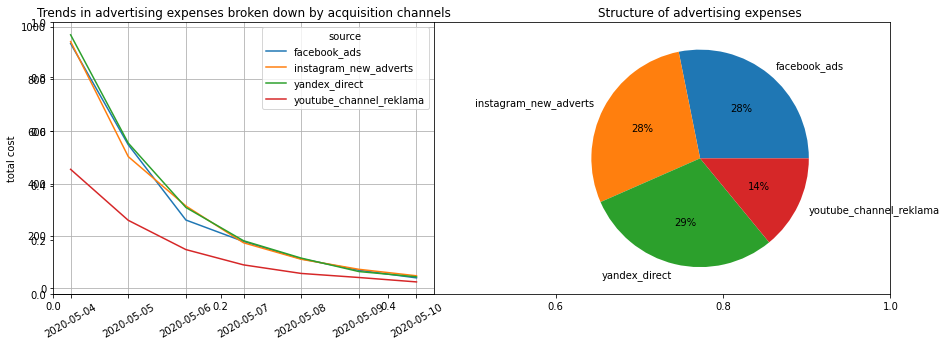

In [25]:
fig, ax = plt.subplots(figsize = (15, 5))

ad_costs.pivot_table(index = 'day', 
                  columns = 'source', 
                  values = 'cost', 
                  aggfunc='sum'
                 ).plot(grid=True, ax=plt.subplot(1,2,1))
plt.title('Trends in advertising expenses broken down by acquisition channels')
plt.xticks(rotation=30)
plt.xlabel('')
plt.ylabel('total cost')

ad_costs.groupby('source')['cost'].sum().plot.pie(autopct='%1.0f%%', ax=plt.subplot(1,2,2))
plt.title('Structure of advertising expenses')
plt.ylabel('')

plt.show()

Advertising expenses are decreasing exponentially across all acquisition channels. The highest advertising expenses occurred on the first day of the cohort. The advertising budget was distributed across four channels. Three channels received roughly equal shares of the budget: `instagram` (28%), `facebook` (28%), and `yandex` (29%), while one channel received half the amount – `youtube` (14%).

### Trends in the number of new users and the cost of acquiring one user, broken down by sources <a id="count_new_user"></a> 

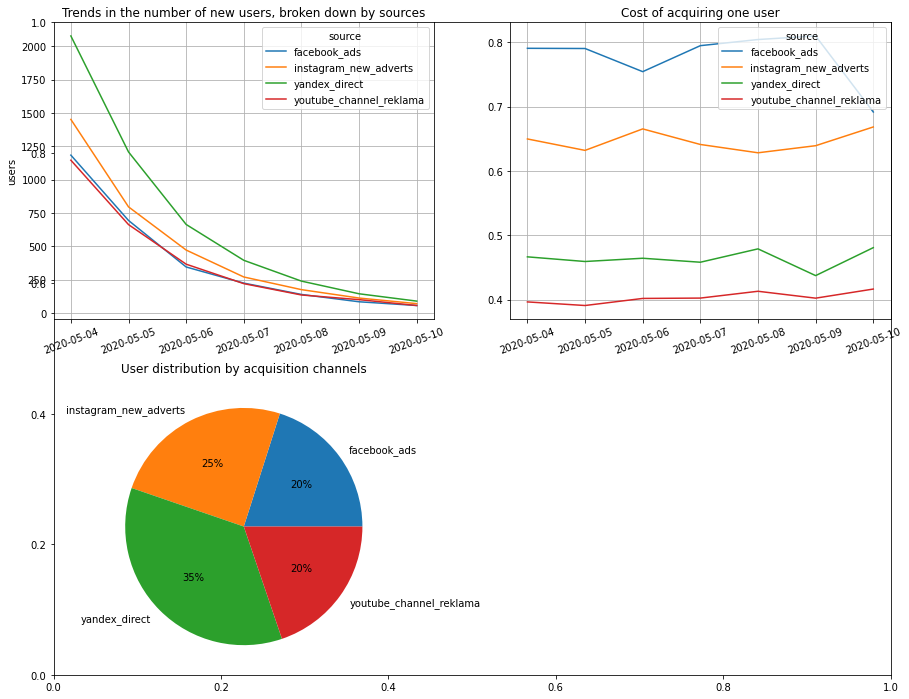

In [26]:
fig, ax = plt.subplots(figsize = (15, 12))

users.pivot_table(index = 'day', 
                  columns = 'source', 
                  values = 'user_id', 
                  aggfunc='count').plot(grid=True, ax=plt.subplot(2,2,1))
plt.title('Trends in the number of new users, broken down by sources')
plt.xticks(rotation=20)
plt.xlabel('')
plt.ylabel('users')

users.pivot_table(index = 'day', 
                  columns = 'source', 
                  values = 'cost_per_user', 
                  aggfunc='mean'
                 ).plot(grid=True, ax=plt.subplot(2,2,2))
plt.title('Cost of acquiring one user')
plt.xticks(rotation=20)
plt.xlabel('')


users.groupby('source')['user_id'].count().plot.pie(autopct='%1.0f%%',
                                                   ax=plt.subplot(2,2,3))
plt.title('User distribution by acquisition channels')
plt.ylabel('')

plt.show()

The largest share of users in this cohort was acquired on May 4th and 5th. After that, the user acquisition trend follows the pattern of advertising expenses.

The most cost-effective acquisition channel (with the lowest cost per user) is `youtube_channel_reklama`. The second most cost-effective channel is `yandex_direct`. The most expensive acquisition channel is `facebook_ads`.

### User distribution by level completion method <a id="users"></a> 

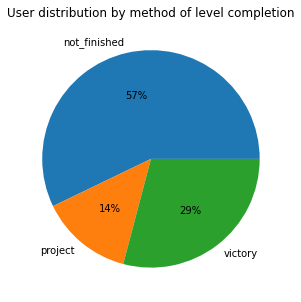

In [27]:
fig, ax = plt.subplots(figsize = (15, 5))
users.groupby('way_end_level')['user_id'].count().plot.pie(autopct='%1.0f%%')
plt.title('User distribution by method of level completion')
plt.ylabel('')

plt.show()

57% of users did not complete the first level of the game. Among those who completed the first level, two-thirds of users defeated the first enemy, and one-third completed the project.

### User distribution by level completion time and number of objects built <a id="users_2"></a>  

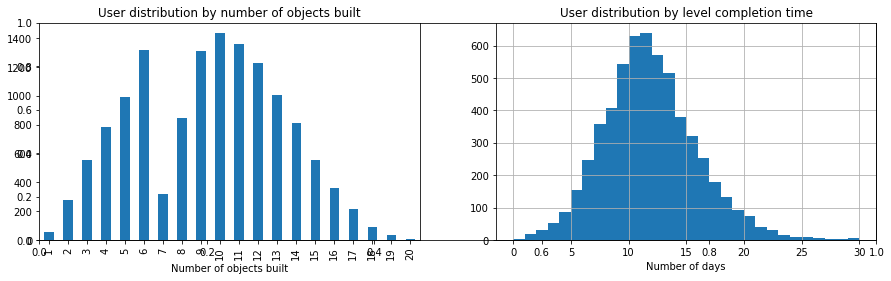

In [28]:
# User distribution by number of objects built
fig, ax = plt.subplots(figsize=(15, 4))

users.groupby('build_count')['user_id'].count().plot.bar(ax=plt.subplot(1, 2, 1))
plt.xlabel('Number of objects built')
plt.title('User distribution by number of objects built')

# User distribution by level completion time
users['days_finished'].hist(bins=30, ax=plt.subplot(1, 2, 2))
plt.title('User distribution by level completion time')
plt.xlabel('Number of days')
plt.show()

The distribution of users by level completion time (in days) is close to a normal distribution, with a peak at 11-12 days.

The distribution of users by the number of objects built is also close to a normal distribution, except for a 'dip' at 7 and 8 objects. The peak occurs at 9-11 objects. The maximum number of objects built by users is 20, and the minimum is 1.

## Analysis of the impact of the game entry source on user behavior <a id="transition_source"></a>

### Level completion time by user, broken down by game entry source <a id="time"></a>

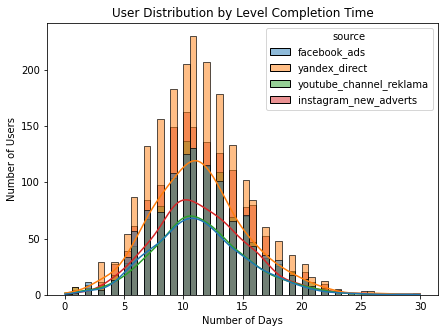

In [29]:
plt.figure(figsize=(7, 5))
sns.histplot(data=users, x='days_finished', hue='source', kde=True)
plt.title('User Distribution by Level Completion Time')
plt.xlabel('Number of Days')
plt.ylabel('Number of Users')
plt.show()

The distribution of users by level completion time (in days) is independent of the game entry source. All distribution graphs have a similar shape, with a peak at 10-11 days. This means that the majority of users complete the level in 10-11 days, regardless of the entry source

### Number of objects built by a user, broken down by game entry source <a id="buildings"></a>  

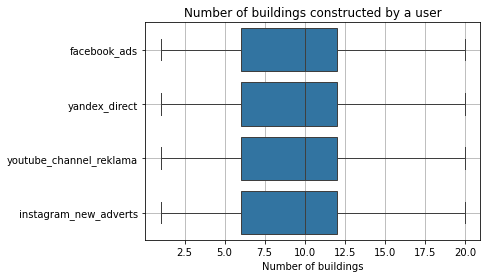

,source,build_count
0,facebook_ads,9.59
1,instagram_new_adverts,9.51
2,yandex_direct,9.35
3,youtube_channel_reklama,9.30


In [30]:
sns.boxplot(data=users, x='build_count', y='source')
plt.title('Number of buildings constructed by a user')
plt.ylabel('')
plt.xlabel('Number of buildings')
plt.grid()
plt.show()

users.groupby('source', as_index=False)['build_count'].mean().round(2)

The charts are almost identical. The median number of objects built is around 10 for all traffic sources. 50% of all users build between 6 and 12 buildings.

The average number of objects built differs slightly. Users who entered the game via `youtube_channel_reklama` build the fewest objects (9.3 objects per user), while users who came through `facebook_ads` build the most (9.59 objects per user).

### Level completion methods, broken down by game entry source  <a id="methods"></a> 

In [31]:
pd.pivot_table(data=users, 
               index='source', 
               columns='way_end_level', 
               values='user_id', 
               aggfunc='count').apply(lambda x: (x * 100) / sum(x), axis=1).round(2)

way_end_level,not_finished,project,victory
source,,,
facebook_ads,57.81,14.34,27.84
instagram_new_adverts,56.20,14.22,29.58
yandex_direct,57.61,12.87,29.52
youtube_channel_reklama,56.85,14.11,29.04


The distribution of users by level completion method does not change significantly depending on the game entry source. The highest proportion of users who did not complete the first level is among those who came from `facebook_ads`, while the lowest is among those who came from `instagram_new_adverts`. The highest proportion of users who completed the first level through project implementation is among those who came from `facebook_ads`, while the lowest is among those who came from `yandex_direct`.

Thus, user behavior differs slightly depending on the entry source – in terms of the average number of objects built and the method of level completion.

Users who came from `facebook_ads` are less likely to complete the first level compared to users from other channels, but they are more likely to complete the level through project implementation.

Users who came from `instagram_new_adverts` are more likely than others to complete the first level, and they are more likely to finish the first level by defeating the first enemy.

Users from `yandex_direct` complete the first level in a manner similar to those from facebook_ads, but they are less likely to finish the level through project implementation compared to other users.

Users who came from `youtube_channel_reklama` have behavior patterns that are roughly in the middle.

## Statistical hypothesis testing<a id="hypotheses"></a>

### Hypothesis 1: The level completion time differs depending on the method of completing the level <a id="hypothes_1"></a>

Null Hypothesis: The level completion time is the same for the two methods of completing the level.

Alternative Hypothesis: The level completion time differs for the two methods of completing the level.

In [32]:
sample_1 = users.query('way_end_level == "project"')['days_finished']
sample_2 = users.query('way_end_level == "victory"')['days_finished']

alpha = .05
results = st.ttest_ind(sample_1, sample_2)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha: 
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

p-значение:  1.8882835392369192e-97
Reject the null hypothesis


We use the method st.ttest_ind to test the hypothesis, as we are comparing the means of two populations based on samples taken from them. Since the samples are of different sizes, we specify the parameter equal_var = False.

Thus, at the 5% significance level, there is sufficient evidence to reject the null hypothesis of equal level completion times for the two methods in favor of the alternative hypothesis.

### Hypothesis 2: The number of objects built by a user differs depending on the traffic source. <a id="hypothes_2"></a>

There are four sources of user entry into the game: `facebook_ads`, `yandex_direct`, `youtube_channel_reklama`, and `instagram_new_adverts`. To test the hypothesis about the difference in the number of objects built by a user, we need to perform pairwise comparisons of the 4 samples.

Therefore, we need to formulate and test 6 null hypotheses.

1. H₀: The mean number of objects built by users from `facebook_ads` is equal to the mean number of objects built by users from `yandex_direct`.

2. H₀: The mean number of objects built by users from `facebook_ads` is equal to the mean number of objects built by users from `youtube_channel_reklama`.

3. H₀: The mean number of objects built by users from `facebook_ads` is equal to the mean number of objects built by users from `instagram_new_adverts`.

4. H₀: The mean number of objects built by users from `yandex_direct` is equal to the mean number of objects built by users from `youtube_channel_reklama`.

5. H₀: The mean number of objects built by users from `yandex_direct` is equal to the mean number of objects built by users from `instagram_new_adverts`.

6. H₀: The mean number of objects built by users from `youtube_channel_reklama` is equal to the mean number of objects built by users from `instagram_new_adverts`.

In [33]:
sample_1 = users.query('source == "facebook_ads"')['build_count']
sample_2 = users.query('source == "yandex_direct"')['build_count']
sample_3 = users.query('source == "youtube_channel_reklama"')['build_count']
sample_4 = users.query('source == "instagram_new_adverts"')['build_count']

alpha = .05

sample_list = [[1, 'facebook_ads > yandex_direct', sample_1, sample_2], 
               [2, 'facebook_ads > youtube_channel_reklama', sample_1, sample_3], 
               [3, 'facebook_ads > instagram_new_adverts', sample_1, sample_4], 
               [4, 'yandex_direct > youtube_channel_reklama', sample_2, sample_3], 
               [5, 'instagram_new_adverts > yandex_direct', sample_4, sample_2],
               [6, 'instagram_new_adverts > youtube_channel_reklama', sample_4, sample_3]]

for number, name, a, b in sample_list:
    results = st.ttest_ind(a, b)
    print(f'Hypothesis test {number}, alternative hypothesis {name}')
    print('p-value: ', results.pvalue)
    if results.pvalue/2 < alpha and a.mean() > b.mean(): 
        print('Reject the null hypothesis')
    else:
        print('Fail to reject the null hypothesis')
    print('-'*30)

Hypothesis test 1, alternative hypothesis facebook_ads > yandex_direct
p-value:  0.010411759321497693
Reject the null hypothesis
------------------------------
Hypothesis test 2, alternative hypothesis facebook_ads > youtube_channel_reklama
p-value:  0.006588846148210501
Reject the null hypothesis
------------------------------
Hypothesis test 3, alternative hypothesis facebook_ads > instagram_new_adverts
p-value:  0.4185321366657372
Fail to reject the null hypothesis
------------------------------
Hypothesis test 4, alternative hypothesis yandex_direct > youtube_channel_reklama
p-value:  0.5972890424874877
Fail to reject the null hypothesis
------------------------------
Hypothesis test 5, alternative hypothesis instagram_new_adverts > yandex_direct
p-value:  0.06989780662351841
Reject the null hypothesis
------------------------------
Hypothesis test 6, alternative hypothesis instagram_new_adverts > youtube_channel_reklama
p-value:  0.03897927011517954
Reject the null hypothesis
----

For hypothesis testing, I used a one-tailed Student's t-test.
Based on the results of the tests, at a 5% significance level, there is enough evidence to reject the null hypotheses 1, 2, 5, and 6 in favor of the alternative hypotheses. The null hypotheses 3 and 4 were not rejected.

Thus, with 95% confidence, the average number of objects built by users coming from `facebook_ads` is greater than that of users coming from `yandex_direct` and `youtube_channel_reklama`.
And, with 95% confidence, the average number of objects built by users coming from `instagram_new_adverts` is greater than that of users coming from `yandex_direct` and `youtube_channel_reklama`.

## Conclusion <a id="conclusion"></a>

1. Users come to the game through four channels: `yandex_direct`, `youtube_channel_reklama`, `facebook_ads`, and `instagram_new_adverts`. The largest share of users came through `yandex_direct` (35%).

2. The lowest cost per user acquisition is found in the `yandex_direct` and `youtube_channel_reklama` channels.

3. More than half of the users (57%) do not complete the first level. Of those who do complete it, one-third finish it through project realization, while two-thirds complete it by defeating the first enemy.

4. The time taken to complete the level by users differs depending on the method used to complete it.

5. User behavior slightly varies depending on the acquisition channel. Since ads are shown on the screen where users select a building to construct, the number of buildings constructed is an important factor. 
There are small, but statistically significant (at the 5% significance level) differences in this metric across the acquisition channels. The most objects are built by users from `facebook_ads` and `instagram_new_adverts`. However, since the cost of user acquisition through these channels is higher than through others, it is necessary to compare the expected user profitability with the costs of acquiring them.